# Analysis

## Data Preparation & Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.model_selection import cross_val_score
from sklearn import grid_search
import seaborn as sns
from sklearn.preprocessing import normalize

/Users/wliao/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/wliao/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Read in data
df = pd.read_csv('creditcard.csv')

In [3]:
# Preview data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Evaluate for class imbalance
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
# Undersample to counteact class imbalance
from imblearn.under_sampling import RandomUnderSampler
usampler = RandomUnderSampler()

In [6]:
X = df.drop('Class',axis=1)
Y = df['Class']

X_sm, Y_sm = usampler.fit_sample(X,Y)

sm_features = pd.DataFrame(data=X_sm,columns=X.columns)
sm_target = pd.DataFrame(data=Y_sm, columns = ['Class'])

frames = [sm_features, sm_target]
sm_data = pd.concat(frames,axis=1)

X = normalize(sm_features)
y = sm_target.values.ravel()

In [7]:
# Verify that classes are now balanaced
sm_data['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

## Experimentation with Different Models

In [9]:
scores = []
model = []
run_time = []

### Naive Bayes

Naive Bayes' simplicity affords it a very quick training speed, let's so how the model performs. 

In [10]:
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
bnb = BernoulliNB()

bnb.fit(X_train,y_train)

start_time = time.time()
nb_scores = cross_val_score(bnb,X_test,y_test,cv=5)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)

nb_score = np.mean(nb_scores)
scores.append(nb_score)
model.append("Naive Bayes")
print("Mean score:", nb_score)

y_pred = bnb.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

--- 0.0076601505279541016 seconds ---
Mean score: 0.901798168712


Predicted,0,1,All
True,,,
0,139,0,139
1,29,128,157
All,168,128,296


The model generalizes well with our test data, achieving an average of 91% accuracy during cross validation. 

### Decision Tree
Decision trees also train relatively quickly and have the added benefit of being easy to interpret, this may make more sense to use than Naive Bayes pending the model's performance. 

In [11]:
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier()
parameters = {'criterion':('gini','entropy'),'max_depth':list(range(1,11,1)),'max_features':list(range(1,5,1))}
gs = grid_search.GridSearchCV(decision_tree, parameters,cv= 3,scoring="accuracy")
gs.fit(X_train,y_train)

decision_tree = tree.DecisionTreeClassifier(**gs.best_params_)
decision_tree.fit(X_train,y_train)


start_time = time.time()
decision_tree_scores = cross_val_score(decision_tree, X_test, y_test, cv=5)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)

decision_tree_score = np.mean(decision_tree_scores)
scores.append(decision_tree_score)
model.append("Decision Tree")
print("Mean score:", decision_tree_score)
print("Optimal parameters:", gs.best_params_)

y_pred = decision_tree.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

--- 0.006902933120727539 seconds ---
Mean score: 0.871281901422
Optimal parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 4}


Predicted,0,1,All
True,,,
0,136,3,139
1,26,131,157
All,162,134,296


Unfortunately the model's performance is inferior to Naive Bayes -- let's explore other models before considering this one. 

### Random Forest

A random forests model may yield superior performance to the previous models run. However, we lose interpretability and it takes longer to train a random forest model. 

In [12]:
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()

parameters = {'n_estimators':list(range(1,100,10)),'max_depth':list(range(1,10,1)),'max_features':list(range(1,5,1))}
gs = grid_search.GridSearchCV(rfc, parameters,cv= 3,scoring="accuracy")
gs.fit(X_train,y_train)

rfc = ensemble.RandomForestClassifier(**gs.best_params_)
rfc.fit(X_train,y_train)

start_time = time.time()
rfc_scores = cross_val_score(rfc,X_test,y_test,cv=5)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)

rfc_score = np.mean(rfc_scores)
scores.append(rfc_score)
model.append("Random Forest")
print("Mean score:", rfc_score)
print("Optimal parameters:", gs.best_params_)

y_pred = rfc.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

--- 0.2349839210510254 seconds ---
Mean score: 0.89507500487
Optimal parameters: {'max_depth': 4, 'max_features': 4, 'n_estimators': 31}


Predicted,0,1,All
True,,,
0,136,3,139
1,22,135,157
All,158,138,296


The random forest model performs similarly to Naive Bayes. The Naive Bayes classifier is still superior given its faster training time and comparable performance. 

### KNN

KNN trains relatively quickly and can be interpreted.

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

parameters = {'n_neighbors':list(range(1,50,1)),'weights':('uniform','distance'),'algorithm':('auto','ball_tree','kd_tree','brute')}
gs = grid_search.GridSearchCV(knn, parameters,cv= 3,scoring="accuracy")
gs.fit(X_train,y_train)

knn = KNeighborsClassifier(**gs.best_params_)
knn.fit(X_train, y_train)

start_time = time.time()
knn_scores = cross_val_score(knn, X_test, y_test, cv=5)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)

knn_score = np.mean(knn_scores)
scores.append(knn_score)
model.append("KNN")
print("Mean score:", knn_score)
print("Optimal parameters:", gs.best_params_)

y_pred = knn.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

--- 0.011312246322631836 seconds ---
Mean score: 0.827377751802
Optimal parameters: {'algorithm': 'auto', 'n_neighbors': 4, 'weights': 'distance'}


Predicted,0,1,All
True,,,
0,128,11,139
1,23,134,157
All,151,145,296


The KNN model remains inferior to our Naive Bayes and Random Forest Classifiers, however it's still a contender alongside Decision Trees as they both strike a balance between performance and interpretability. 

### Logistic Regression

Logistic regression trains to the data quite quickly, let's see how the model performs. 

In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,y_train)

start_time=time.time()
lr_scores = cross_val_score(lr,X_test,y_test,cv=5)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)

lr_score = np.mean(lr_scores)
scores.append(lr_score)
model.append("Logistic Regression")
print(lr_score)

y_pred = lr.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

--- 0.01549220085144043 seconds ---
0.530399376583


Predicted,0,1,All
True,,,
0,139,0,139
1,156,1,157
All,295,1,296


### SVM

In [15]:
from sklearn.svm import SVC

svc = SVC(C=1000000)
svc.fit(X_train,y_train)

start_time=time.time()
svc_scores = cross_val_score(svc,X_test,y_test,cv=5)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)

svc_score = np.mean(svc_scores)
scores.append(svc_score)
model.append("SVC")
print(svc_score)

y_pred = svc.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

--- 0.05453610420227051 seconds ---
0.675378920709


Predicted,0,1,All
True,,,
0,138,1,139
1,105,52,157
All,243,53,296


### Boosting

In [16]:
from sklearn import grid_search

gradient_boost = ensemble.GradientBoostingClassifier()
parameters = {'n_estimators':list(range(1,501,50)),'max_depth':list(range(1,11,2)),'loss':('exponential','deviance')}
gs = grid_search.GridSearchCV(gradient_boost, parameters,cv= 3,scoring="accuracy")
gs.fit(X_train,y_train)

clf = ensemble.GradientBoostingClassifier(**gs.best_params_)
clf.fit(X_train, y_train)

start_time = time.time()
clf_scores = cross_val_score(clf,X_test,y_test,cv=5)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)

clf_score = np.mean(clf_scores)
scores.append(clf_score)
model.append("Boosting")
print(clf_score)

y_pred = clf.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

--- 0.2848780155181885 seconds ---
0.922312487824


Predicted,0,1,All
True,,,
0,134,5,139
1,14,143,157
All,148,148,296


## Evaluation

Overall, Naive Bayes appears to be the superior model for our particular data set. It performs exceptionally well relative to the other models and has runs extremely quickly. 

One caveat to point out with the Naive Bayes model is that it's prone to making Type II errors, which means that there will be instances where the model classifies an account as nonfraudulent when in actuality fraud is being committed. Another option is to utilize Boosting. At the expense of a longer training time, you get a model that appears to be slightly less biased towards Type II errors. 

Both of these models, however, ultimately lack in interpretability. If interpretability is essential for the credit card company to utilize the model, then the Decision Tree model performs slightly worse but is much easier to explain. 

In [17]:
results = pd.DataFrame()
results['scores'] = scores
results['model'] = model
results['run_time'] = run_time

In [18]:
results = results.sort_values(by=['scores'])

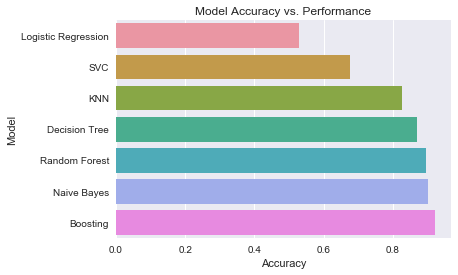

In [25]:
sns.barplot(x=results['scores'],y=results['model'])
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Accuracy vs. Performance")

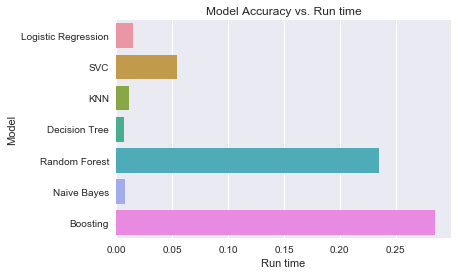

In [24]:
sns.barplot(x=results['run_time'],y=results['model'])
plt.xlabel("Run time")
plt.ylabel("Model")
plt.title("Model Accuracy vs. Run time")